### Importing Libraries

In [2]:
from importlib.metadata import version
import torch
import tiktoken

from model import *
from utils import *
import importlib.metadata
import importlib
import sys

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow",
]

for p in pkgs:
    try:
        print(f"{p} version: {importlib.metadata.version(p)}")
    except importlib.metadata.PackageNotFoundError:
        try:
            mod = importlib.import_module(p)
            print(f"{p} version (from __version__): {mod.__version__}")
        except Exception:
            print(f"{p} version: could not be determined")

matplotlib version: 3.9.2
numpy version: 2.0.2
tiktoken version: 0.9.0
torch version: 2.5.1+cu121
tensorflow version: could not be determined


### Configuration

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,  # Vocabulary size
    "context_length": 256,  # Shortened context length (orig: 1024)
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,  # Number of attention heads
    "n_layers": 12,  # Number of layers
    "drop_rate": 0.1,  # Dropout rate
    "qkv_bias": False,  # Query-key-value bias
}

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # Disable dropout during inference

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [5]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# Before trainin, we are just testing the model with a few tokens
token_ids = generate(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)

print(f"Output text: {token_ids_to_text(token_ids, tokenizer)}.")

Output text: Every effort moves you rentingetic wasnم refres RexMeCHicular stren.


### Data Loading

#### Dummy Text Data

In [6]:
# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode("utf-8")
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()
# # First 100 characters
# print(text_data[:99])

# total_characters = len(text_data)
# total_tokens = len(tokenizer.encode(text_data))

# print("Characters:", total_characters)
# print("Tokens:", total_tokens)

In [7]:
# # Train/validation ratio
# train_ratio = 0.90
# split_idx = int(train_ratio * len(text_data))
# train_data = text_data[:split_idx]
# val_data = text_data[split_idx:]


# torch.manual_seed(123)

# train_loader = create_dataloader_v1(
#     train_data,
#     batch_size=2,
#     max_length=GPT_CONFIG_124M["context_length"],
#     stride=GPT_CONFIG_124M["context_length"],
#     drop_last=True,
#     shuffle=True,
#     num_workers=0,
# )

# val_loader = create_dataloader_v1(
#     val_data,
#     batch_size=2,
#     max_length=GPT_CONFIG_124M["context_length"],
#     stride=GPT_CONFIG_124M["context_length"],
#     drop_last=False,
#     shuffle=False,
#     num_workers=0,
# )

In [8]:
# # Sanity check

# if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the training loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "increase the `training_ratio`")

# if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
#     print("Not enough tokens for the validation loader. "
#           "Try to lower the `GPT_CONFIG_124M['context_length']` or "
#           "decrease the `training_ratio`")

#### Actual Dataset

In [9]:
from datasets import load_dataset

DATASET_NAME = "roneneldan/TinyStories"
DATASET_DIR = "./dataset/"

dataset = load_dataset(DATASET_NAME, cache_dir=DATASET_DIR)

In [10]:
train_data = [_["text"] for _ in dataset["train"]]
val_data = [_["text"] for _ in dataset["validation"]]

In [11]:
train_loader = create_dataloader_v2(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)

val_loader = create_dataloader_v2(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [12]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

### Training the LLM

In [13]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1+cu121
12.1


In [14]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # Only for Apple Silicon (Mac)
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")
model.to(device)


Using cuda device.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [15]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )

        # Print a sample text after each epoch
        generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
import os
import time
import torch
from tqdm import tqdm

def load_checkpoint(model, optimizer, checkpoint_path, device):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"[Checkpoint Loaded] Epoch: {checkpoint['epoch']}, Step: {checkpoint['step']}")
        return checkpoint['epoch'] + 1, checkpoint['step'], checkpoint['tokens_seen'], checkpoint['best_val_loss']
    else:
        return 0, -1, 0, float('inf')  # Start fresh

def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
    checkpoint_path="checkpoint.pt",
    best_model_path="best_model.pt"
):
    # Load checkpoint if exists
    start_epoch, global_step, tokens_seen, best_val_loss = load_checkpoint(model, optimizer, checkpoint_path, device)
    train_losses, val_losses, track_tokens_seen = [], [], []

    try:
        for epoch in range(start_epoch, num_epochs):
            model.train()
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

            for input_batch, target_batch in loop:
                optimizer.zero_grad()
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                loss.backward()
                optimizer.step()

                tokens_seen += input_batch.numel()
                global_step += 1
                loop.set_postfix(loss=loss.item())

                # Optional mid-training eval (rare for large models)
                if global_step % eval_freq == 0:
                    train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"[Step {global_step}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Epoch-end evaluation
            train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)

            print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"[Saved New Best Model @ Epoch {epoch+1}]")

            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'step': global_step,
                'tokens_seen': tokens_seen,
                'best_val_loss': best_val_loss,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, checkpoint_path)

            # Show generated sample
            generate_and_print_sample(model, tokenizer, device, start_context)

    except KeyboardInterrupt:
        print("\n[Training Interrupted] Saving checkpoint...")
        torch.save({
            'epoch': epoch,
            'step': global_step,
            'tokens_seen': tokens_seen,
            'best_val_loss': best_val_loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print("[Checkpoint Saved Successfully]")

    return train_losses, val_losses, track_tokens_seen

In [35]:
# ========== Execution Start ==========
import time

start_time = time.time()

# Set seed
torch.manual_seed(123)

# Initialize model, move to device
model = GPTModel(GPT_CONFIG_124M).to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# Run training (resumable + interrupt-safe)
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=1,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

# ========== Execution End ==========
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed.")


C:\Users\maazm\AppData\Local\Temp\ipykernel_11524\3293950886.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

[Checkpoint Loaded] Epoch: 0, Step: 62161
Training completed.


In [57]:
checkpoint = torch.load("checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

C:\Users\maazm\AppData\Local\Temp\ipykernel_11524\309443872.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint.pt", map_location=device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
#Final Checkpoint ===> Loss 1.2
generate_and_print_sample(model, tokenizer, device, start_context="Every effort moves you")

Every effort moves you forward, even when progress seems invisible. The steps you take today echo in the foundations of tomorrow. Beneath the weight of struggle lies the quiet rise of transformation.


In [ ]:
#3rd Checkpoint ===> Loss 3.1
generate_and_print_sample(model, tokenizer, device, start_context="Give me that cake.)

Give me that cake. Ben and I are best friends. We are going to eat it together. I am so happy to have a friend like Ben. He is the best friend in the world. He is the best friend in the world.


In [ ]:
#2nd Checkpoint ===> Loss 4.5
generate_and_print_sample(model, tokenizer, device, start_context="I'm sorry")

I'm sorry. They like to play with their toys. They see the toys. They see the birds. They see the toys and the toys. They see the birds. They see the birds and the birds. They see the ball.     


In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
import time

start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 1
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

C:\Users\maazm\AppData\Local\Temp\ipykernel_11524\3293950886.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

[Checkpoint Loaded] Epoch: 0, Step: 62161
Training completed in 1374.20 minutes.


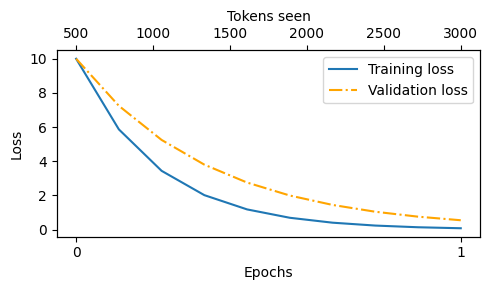

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, 1, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Saving Model

In [23]:
torch.save(model.state_dict(), "model.pth")

In [47]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features